# News Processing and Financial Sentiment Extraction Notebook

In this notebook, we would like to clean the raw news CSV file and use the processed news data for financial sentiment extraction using the FinBert model.

## Tesla Data Download from Yahoo Finance 

In [1]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Libraries

In [2]:
import pandas as pd
import yfinance as yf

### Const Values

In [3]:
DATE_COLUMN_NAME = "Date"

### Methods

In [4]:
def save_df_in_path(df, path):
    df.to_csv(path)

### Code

In [5]:
ticker = "TSLA"
data_csv_file_path = f"../Data/PAPER_{ticker}_data.csv"

data_df = yf.download(
    ticker, 
    start="2014-01-01", 
    end="2020-01-01"
)

data_df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2014-01-02 00:00:00+00:00,10.006667,10.006667,10.165333,9.770000,9.986667,92826000
2014-01-03 00:00:00+00:00,9.970667,9.970667,10.146000,9.906667,10.000000,70425000
2014-01-06 00:00:00+00:00,9.800000,9.800000,10.026667,9.682667,10.000000,80416500
2014-01-07 00:00:00+00:00,9.957333,9.957333,10.026667,9.683333,9.841333,75511500
2014-01-08 00:00:00+00:00,10.085333,10.085333,10.246667,9.917333,9.923333,92448000


In [6]:
data_df.columns = data_df.columns.get_level_values(0)
data_df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-01-02 00:00:00+00:00,10.006667,10.006667,10.165333,9.770000,9.986667,92826000
2014-01-03 00:00:00+00:00,9.970667,9.970667,10.146000,9.906667,10.000000,70425000
2014-01-06 00:00:00+00:00,9.800000,9.800000,10.026667,9.682667,10.000000,80416500
2014-01-07 00:00:00+00:00,9.957333,9.957333,10.026667,9.683333,9.841333,75511500
2014-01-08 00:00:00+00:00,10.085333,10.085333,10.246667,9.917333,9.923333,92448000


In [7]:
save_df_in_path(data_df, data_csv_file_path)

In [8]:
data_df = pd.read_csv(data_csv_file_path)
data_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-01-02 00:00:00+00:00,10.006667,10.006667,10.165333,9.770000,9.986667,92826000
1,2014-01-03 00:00:00+00:00,9.970667,9.970667,10.146000,9.906667,10.000000,70425000
2,2014-01-06 00:00:00+00:00,9.800000,9.800000,10.026667,9.682667,10.000000,80416500
3,2014-01-07 00:00:00+00:00,9.957333,9.957333,10.026667,9.683333,9.841333,75511500
4,2014-01-08 00:00:00+00:00,10.085333,10.085333,10.246667,9.917333,9.923333,92448000


In [9]:
data_df[DATE_COLUMN_NAME] = pd.to_datetime(data_df[DATE_COLUMN_NAME]).dt.date
data_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-01-02,10.006667,10.006667,10.165333,9.770000,9.986667,92826000
1,2014-01-03,9.970667,9.970667,10.146000,9.906667,10.000000,70425000
2,2014-01-06,9.800000,9.800000,10.026667,9.682667,10.000000,80416500
3,2014-01-07,9.957333,9.957333,10.026667,9.683333,9.841333,75511500
4,2014-01-08,10.085333,10.085333,10.246667,9.917333,9.923333,92448000


In [10]:
save_df_in_path(data_df, data_csv_file_path)

## News Processing

### Pip Install Commands

In [11]:
%pip install demoji
%pip install contractions

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Libraries

In [12]:
import demoji
import contractions

### Const Values

In [13]:
TIME_COLUMN_NAME = "Time"
NEWS_COLUMN_NAME = "Tweet"
LEFTOVER_COLUMN_NAME = "Leftover"

NEWS_COLUMNS_LIST = [
    DATE_COLUMN_NAME,
    NEWS_COLUMN_NAME,
    LEFTOVER_COLUMN_NAME
]

RAW_AMPERSAND_VALUE = "&amp"

### Methods

In [14]:
def get_date_data(time_stamp):
    # get date data by space split
    date = time_stamp.split(" ")[0]
    return date

In [15]:
def get_time_data(time_stamp):
    # get date data by space and plus split
    time_stamp = time_stamp.split(" ")[1]
    time = time_stamp.split("+")[0]
    return time

In [16]:
def replace_raw_ampersand_value(text):
    # replace &amp with &
    text = text.replace(RAW_AMPERSAND_VALUE, "&")

    # replace &; with &
    text = text.replace("&;", "&")

    return text

In [17]:
def merge_news_leftover(row):
    news_separator = ""
    current_news_data = row[NEWS_COLUMN_NAME]
    amp_flag = RAW_AMPERSAND_VALUE in current_news_data

    if pd.notna(row[LEFTOVER_COLUMN_NAME]):
        if amp_flag:
            current_news_data = replace_raw_ampersand_value(
                current_news_data)
            
            # concat news data together without space
            news_separator = ""

        # concat news and leftover data together
        leftover_data = row[LEFTOVER_COLUMN_NAME]
        current_news_data += f"{news_separator}{leftover_data}"
    
    return current_news_data

In [18]:
def process_news_data(news_data):
    # delete any new lines and use only the first main title
    news_data = news_data.split("\n")[0]

    # delete any links for news data
    news_data = news_data.split("http")[0]

    # delete any emoji characters
    news_data = demoji.replace(news_data, repl="")
    
    news_data = replace_raw_ampersand_value(news_data)
    
    # expend contractions in news data
    news_data = contractions.fix(news_data, slang=False)
    
    # delete any spaces at the start or end of the news data
    news_data = news_data.strip()

    return news_data

### Code

Loading news dataframe and deleting any columns that are not Date or news data

In [19]:
news_df = pd.read_csv("../Data/tweets.csv")

In [20]:
for current_column in news_df.columns:
    if current_column not in NEWS_COLUMNS_LIST:
        news_df = news_df.drop(current_column, axis=1)

Splitting Date data to separate Date and Time columns

In [21]:
# adding a new column for the time
news_df[TIME_COLUMN_NAME] = news_df[DATE_COLUMN_NAME].apply(
    get_time_data)

# amend existing date column
news_df[DATE_COLUMN_NAME] = news_df[DATE_COLUMN_NAME].apply(
    get_date_data)

Processing the news data

In [22]:
news_df[NEWS_COLUMN_NAME] = news_df[NEWS_COLUMN_NAME].apply(
    process_news_data)

Concatenating misaligned news data with the main news column

In [23]:
news_df[NEWS_COLUMN_NAME] = news_df.apply(
    merge_news_leftover, 
    axis=1)

news_df = news_df.drop(LEFTOVER_COLUMN_NAME, axis=1)

In [24]:
news_df[NEWS_COLUMN_NAME] = news_df[NEWS_COLUMN_NAME].apply(
    process_news_data)

In [25]:
news_df.head()

,Date,Tweet,Time
0,2023-04-10,"Tesla to open a new Megafactory in Shanghai, C...",01:00:00
1,2023-04-10,#5things: China holds military drills around T...,00:06:05
2,2023-04-09,WATCH: Tesla Chief Executive Elon Musk is maki...,22:10:00
3,2023-04-09,Tesla’s Model S and X are starting to show the...,21:41:02
4,2023-04-09,"How the market’s biggest companies, from Apple...",20:00:00


Saving processed dataframe

In [26]:
news_df.to_csv("../Data/processed_tweets.csv")

## Financial Sentiment Extraction

### Pip Install Commands

In [27]:
%pip install torch
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Libraries

In [28]:
import torch
from enum import Enum
from torch.nn.functional import softmax
from transformers import BertTokenizer, BertForSequenceClassification

/home/shartil/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Const Values

In [29]:
SENTIMENT_COLUMN_NAME = "Sentiment"

class Sentiment(Enum):
    POSITIVE = 0
    NEGATIVE = 1
    NEUTRAL  = 2

TOKENIZER = BertTokenizer.from_pretrained(
    'ProsusAI/finbert')

MODEL = BertForSequenceClassification.from_pretrained(
    'ProsusAI/finbert')

### Methods

In [30]:
def get_news_from_date(news_df, date):
    return news_df[news_df[DATE_COLUMN_NAME].astype(str) == date]

In [31]:
def get_sentiment_probabilities(news_data):
    # tokenize input
    inputs = TOKENIZER(news_data, 
                       return_tensors='pt', 
                       truncation=True, 
                       padding=True)

    # perform prediction
    with torch.no_grad():
        outputs = MODEL(**inputs)

    # get logits and apply softmax to get probabilities
    logits = outputs.logits
    probabilities = softmax(logits, dim=1)

    # convert pytorch tensor to numpy array
    return probabilities.numpy()[0]

In [32]:
def get_sentiment_score(date):
    sentiment_category = 0
    psitive_sentiment_avg = 0
    negative_sentiment_avg = 0

    # get news from given date
    date_news = get_news_from_date(news_df, date)
    amount_of_news = len(date_news)

    # in case no news were published on given date, return 0
    if amount_of_news == 0:
        return sentiment_category

    for i in range(amount_of_news):
        current_news = date_news[NEWS_COLUMN_NAME].iloc[i]
        sentiment_probabilities = get_sentiment_probabilities(
            current_news)
        
        # sum positive probability
        psitive_sentiment_avg += sentiment_probabilities[
            Sentiment.POSITIVE.value]

        # sum negative probability
        negative_sentiment_avg += sentiment_probabilities[
            Sentiment.NEGATIVE.value]

    # calculate average of positive and negative probabilities sums  
    psitive_sentiment_avg /= amount_of_news
    negative_sentiment_avg /= amount_of_news
    
    # compare average values and assign sentiment category
    if psitive_sentiment_avg > negative_sentiment_avg:
        sentiment_category = 1
    else:
        sentiment_category = -1
    
    return sentiment_category

### Code

Loading TESLA stock data frame

In [33]:
tesla_stock_df = pd.read_csv(data_csv_file_path, index_col=0)
tesla_stock_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-01-02,10.006667,10.006667,10.165333,9.770000,9.986667,92826000
1,2014-01-03,9.970667,9.970667,10.146000,9.906667,10.000000,70425000
2,2014-01-06,9.800000,9.800000,10.026667,9.682667,10.000000,80416500
3,2014-01-07,9.957333,9.957333,10.026667,9.683333,9.841333,75511500
4,2014-01-08,10.085333,10.085333,10.246667,9.917333,9.923333,92448000


Getting sentiment score for each trading day in TESLA stock data frame

In [34]:
tesla_stock_df[SENTIMENT_COLUMN_NAME] = tesla_stock_df[
    DATE_COLUMN_NAME].apply(get_sentiment_score)

tesla_stock_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Sentiment
0,2014-01-02,10.006667,10.006667,10.165333,9.770000,9.986667,92826000,0
1,2014-01-03,9.970667,9.970667,10.146000,9.906667,10.000000,70425000,0
2,2014-01-06,9.800000,9.800000,10.026667,9.682667,10.000000,80416500,0
3,2014-01-07,9.957333,9.957333,10.026667,9.683333,9.841333,75511500,0
4,2014-01-08,10.085333,10.085333,10.246667,9.917333,9.923333,92448000,0


Saving the processed TESLA stock data frame

In [35]:
save_df_in_path(tesla_stock_df, f"../Data/processed_PAPER_{ticker}_data.csv")

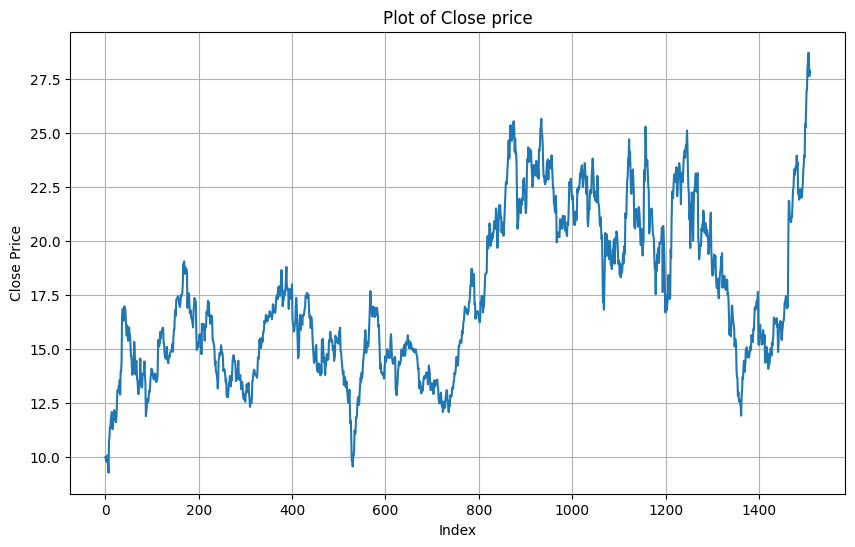

In [38]:
#test code to varify that we got the same plot as fig 1. in paper
import matplotlib.pyplot as plt

# Replace 'column_name' with the actual column you want to plot
tesla_stock_df["Close"].plot(kind='line', figsize=(10, 6))

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Plot of Close price')
plt.grid(True)

# Show the plot
plt.show()